<font color='DarkBlue' size=+2><b>Комментарий ревьюера</b></font><br>
<font color='DarkBlue'>Привет, Ярослав! <br>Меня зовут Олег Мазуренко, и я буду проверять этот проект. Спасибо за проделанную работу! <br>Ко мне можно обращаться на «ты». Как мне обращаться, напиши.</font><br>
<font color='DarkBlue'>Я буду использовать различные цвета, чтобы было удобнее воспринимать мои комментарии:</font><br>
<font color='DarkBlue'>Синий текст &mdash; просто текст комментария.</font><br>
<font color='DarkGreen'>👌 Зеленый текст &mdash; все отлично.</font><br>
<font color='DarkMagenta'>👉 Фиолетовый текст &mdash; сделано все правильно, однако есть рекомендации, на что стоит обратить внимание. Реализованные рекомендации позволят нам наработать опыт решения задачи разными способами или посмотреть на задачу под иным углом.</font><br>
<font color='Red'>🛠 Красный текст &mdash; есть недочеты, они иногда бывают. </font><br><font color='DarkBlue'>Любая ошибка это возможность посмотреть на задачу с другой стороны и освоить новые знания, по этому не надо расстраиваться, если они есть.</font><br>
<font color='DarkBlue'>Обращаю внимание, что комментарии ревьюера после проверки удалять нельзя они помогают отследить логику исправления или изменения проекта. Это дополнительный навык при обучении. Свой исправляемый код лучше тоже не удалять, а ремить #, это позволит акцентировать изменения в ходе подготовки окончательного варианта проекта.<br>
Ответы на мои комментарии лучше тоже помечать. 
Например: </font><font color='Blue'><b>Комментарий студента</b></font><br>
<font color='DarkBlue'><b>Теперь посмотрим, что получилось!</b></font>

# Проверка гипотез о выручке проката самокатов

Нужно изучить модели монетизации сервиса аренды электросамокатов по подписке и без подписки.

## Цель
Сформулировать полезные для повышения выручки выводы.

## Описание данных:
### Пользователь
- `user_id` — уникальный идентификатор пользователя
- `name` — имя пользователя
- `age` — возраст
- `city`— город
- `subscription_type` — тип подписки (free, ultra)
### Поездки 
- `user_id` — уникальный идентификатор пользователя
- `distance` — расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` — дата совершения поездки
### Подписки
- `subscription_type` — тип подписки
- `minute_price` — стоимость одной минуты поездки по данной подписке
- `start_ride_price` — стоимость начала поездки
- `subscription_fee` — стоимость ежемесячного платежа

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Было бы правильно добавить план исследования в описание проекта.</font>

## План исследования

</font><font color='Blue'><b>Комментарий студента</b></font><br>
1) Подготовка и фильтрация данных
2) Объединение данных в удобные для анализа срезы
3) Исследовательский анализ пользователей по различным группам: город, тип подписки, расстаяние и продолжительность поездки и т.п. для знакомства с данными
4) Проверка гипотез об использовании сервиса
5) Общие выводы на основании проверенных гипотез и аналитики

In [2]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dt
import math
from scipy import stats as st

## Подготовка данных

### Откроем файлы с данными и изучим общую информацию

In [3]:
try:
    users = pd.read_csv(r".\source\users_go.csv")
    rides = pd.read_csv(r".\source\rides_go.csv")
    subscriptions = pd.read_csv(r".\source\subscriptions_go.csv")
except:
    users = pd.read_csv("/datasets/users_go.csv")
    rides = pd.read_csv("/datasets/rides_go.csv")
    subscriptions = pd.read_csv("/datasets/subscriptions_go.csv")

pd.set_option('display.max_columns', None)
print(f"Users:\n{users  .head(20)}")
print(f"Rides:\n{rides.head(20)}")
print(f"Subscriptions:\n{subscriptions.head(20)}")

Users:
    user_id        name  age            city subscription_type
0         1        Кира   22          Тюмень             ultra
1         2   Станислав   31            Омск             ultra
2         3     Алексей   20          Москва             ultra
3         4  Константин   26  Ростов-на-Дону             ultra
4         5       Адель   28            Омск             ultra
5         6      Регина   25       Краснодар             ultra
6         7       Игорь   23            Омск             ultra
7         8        Юрий   23       Краснодар             ultra
8         9          Ян   21       Пятигорск             ultra
9        10     Валерий   18    Екатеринбург             ultra
10       11       Агата   31       Краснодар             ultra
11       12        Марк   27          Тюмень             ultra
12       13         Ева   24       Краснодар             ultra
13       14    Антонина   18       Пятигорск             ultra
14       15     Валерия   24          Тюмень    

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Очень хорошо, что используется код двойной загрузки, локально и с сервера. Часто в проектах возникают ошибки именно из-за не правильного пути к датасетам.</font>

Преобразуем колонки к соответствующим типам данных.

In [4]:
def print_info():
    users.info()
    rides.info()
    subscriptions.info()

print_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Col

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Следовало сделать краткое резюме по загруженным и проанализированным датасетам.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
Данные в нормализованном виде. Для удобства анализа может быть полезно их объединить в будущем после подготовки. Объём занимаемой данными памяти очень низкий, поэтому оптимизацию типов можно пропустить.

Приведём date в таблице поездок к типу даты.

In [5]:
rides = rides.astype({"date" : "datetime64[ns]"})
print_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, преобразовали колонку `['date']` в дату.</font>

Создадим столбец с номером месяца для удобства.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Следовало проверить за какой период данные в датасете. Если данные за несколько лет, то номера месяцев будут в разных годах одинаковыми.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
В последующих шагах я в связанной с номерами месяцов задаче сделал такой анализ. Вручную проанализировал файл с датами поездок через поиск по номеру года в IDE. Комментарий об этом я не добавлял т.к. на мой взгляд это скорее влияет на реализацию анализа в коде, нежели на полезные для бизнеса выводы. Однако на данном этапе мне не ясно, нужны ли индексы месяцев для сезонного анализа или ID для каждого отдельного месяца (с учётом года), поэтому тут я ничего явно не указал и не проверил программно.

In [6]:
rides["month_number"] = rides["date"].dt.month

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Правильно выполнено задание по созданию столбца с номером месяца.</font>
<br><font color='DarkMagenta'>👉 Следовало посмотреть результат преобразований.</font>

In [7]:
rides.head()

,user_id,distance,duration,date,month_number
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


### Обработаем пропуски

In [8]:
print(f"Пропуски в данных о пользователях:\n{users.isna().sum()}")

Пропуски в данных о пользователях:
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Зачем выводить пустые графики? Достаточно вывести пропуски строчкой кода, тем более их нет.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
Согласен, отрефакторил.

In [9]:
print(f"Пропуски в данных о поездках:\n{rides.isna().sum()}")

Пропуски в данных о поездках:
user_id         0
distance        0
duration        0
date            0
month_number    0
dtype: int64


In [10]:
print(f"Пропуски в данных о подписках:\n{subscriptions.isna().sum()}")

Пропуски в данных о подписках:
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


### Обработаем дубликаты

Проверим наличие явных дубликатов.

In [11]:
users.duplicated().sum()

31

Удалим явные убликаты для пользователей и обновим индекс.

In [12]:
users.drop_duplicates(inplace=True)


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Не удалены дубликаты, см. код ниже. </font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
Обновил код

In [13]:
# Комментарий ревьюера
users.duplicated().sum()

0

In [14]:
users = users.reset_index(drop=True)

In [15]:
rides.duplicated().sum()

0

In [16]:
subscriptions.duplicated().sum()

0

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Здесь ожидаются обобщающие выводы по разделу первичного анализа и предобработки данных.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
Данные относительно чистые. Удалены явные дубликаты и исправлен тип данных на дату для колонки date. Создана колонка с индексом месяца.

## EDA

### Ознакомимся с пользователями.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Правильно было бы посмотреть сводную статистику  методом `describe()`.</font>

In [17]:
users.describe()

,user_id,age
count,1534.000000,1534.000000
mean,767.500000,24.903520
std,442.971971,4.572367
min,1.000000,12.000000
25%,384.250000,22.000000
50%,767.500000,25.000000
75%,1150.750000,28.000000
max,1534.000000,43.000000


Средний возраст пользователей сервисом 25 лет. При этом есть пользователи сильно моложе, которым нужно запретить официальное использование сервиса. Пенсионеры и пожилые люди вовсе не пользуются сервисом.

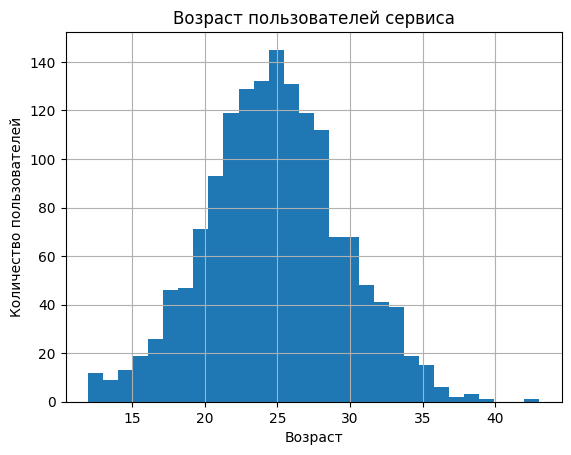

In [18]:
users["age"].hist(bins=30)
plt.title("Возраст пользователей сервиса")
plt.xlabel("Возраст")
plt.ylabel("Количество пользователей")
plt.show()

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Визуализация данных графиками и диаграммами подразумевает подписи всех осей и название графика  на русском языке, при необходимости наличие меток. Это относится ко всем графикам/диаграммам проекта и является критической ошибкой.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
Добавил метаданные на графики.

Чаще всего арендой электросамокатов пользуется молодёжь от 20 до 30 лет. 25 лет — самый популярный возраст.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Следовало отметить, что среди пользователей некоторым менее 18 лет, именно с этого возраста разрешен прокат самокатов. В некоторых компаниях и регионах разрешено с 14 лет, но при письменном согласии родителей. В датасете минимальный возраст 12 лет, это явное нарушение существующих норм.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
Добавил этот вывод выше после анализа описательной статистики.

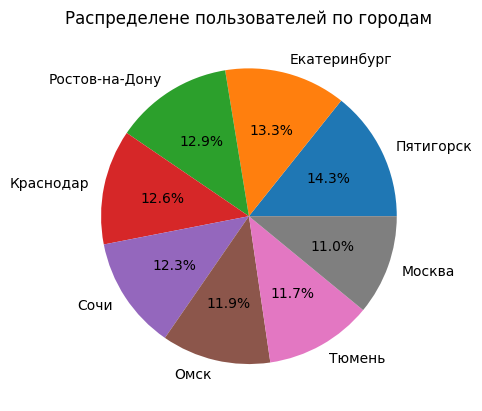

In [19]:
distribution = users["city"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Распределене пользователей по городам")
plt.show()

Пользователи распределены по городам относительно "равномерно".

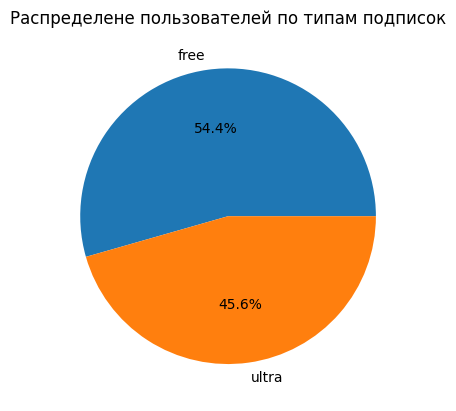

In [20]:
distribution = users["subscription_type"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Распределене пользователей по типам подписок")
plt.show()

Немного больше, около 10% разницы, пользователей, которые пользуются сервисом аренды без подписки.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо сделан анализ и сформулирован промежуточный вывод.</font>

### Ознакомимся с поездками

Рассмотрим расстояние, которое пользователи проезжают за одну поездку.

In [21]:
def rides_frequencies(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.hist(df["distance"], bins=30)
    ax1.set_title('Частота расстояния поездки')
    ax1.set_xlabel("Расстояние в метрах")
    ax1.set_ylabel("Количество пользователей")

    ax2.hist(df["duration"], bins=30)
    ax2.set_title('Частота длительности поездки')
    ax2.set_xlabel("Продолжительность в минутах")
    ax2.set_ylabel("Количество пользователей")

    plt.tight_layout()
    plt.show()

Рассмотрим продолжительность поездок по времени и расстоянию.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Правильно было бы посмотреть сводную статистику расстояний и времени поездок  методом `describe()`.</font>

In [22]:
rides[["distance", "duration"]].describe()

,distance,duration
count,18068.000000,18068.000000
mean,3070.659976,17.805011
std,1116.831209,6.091051
min,0.855683,0.500000
25%,2543.226360,13.597563
50%,3133.609994,17.678395
75%,3776.222735,21.724800
max,7211.007745,40.823963


Видим что пользователи в в среднем проезжают около 3 км и поездка длится около 18 минут.

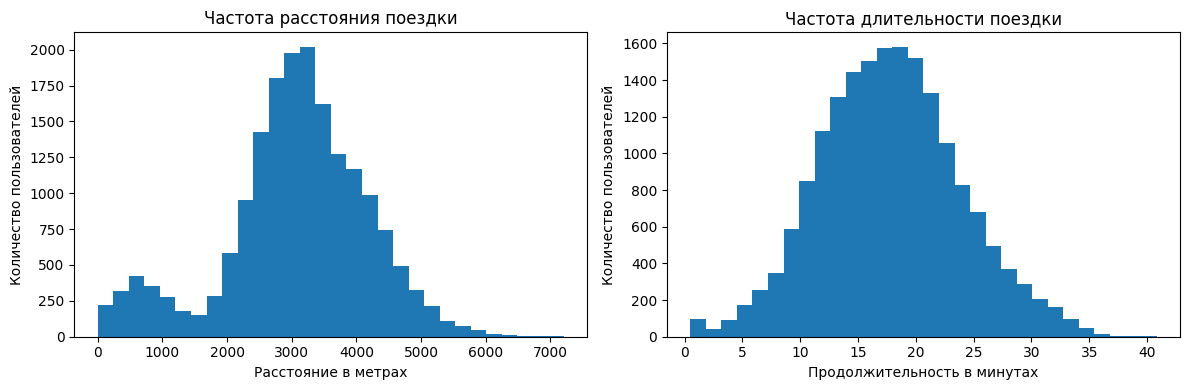

In [23]:
rides_frequencies(rides)

Обратим внимание, что график частот расстояния поездок мультимодальный. Пользователи проезжают либо около 600 метров, либо значительно больше, около 3100 метров.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо сделан анализ расстояния поездок и обращено внимание на короткие поездки и дальние поездки.</font>

График частот времени поездок тоже мультимодальный. Пользователи едут либо около 1 минуты, либо значительно больше, около 19 минут. При этом заметно, что дисперсия графика по продолжительности поездки выше, чем по расстоянию.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, что отмечена аномалия. Только при длительности поездки 0,5 минуты расстояние более 4000 метров.<br>
Не смотря на такую низкую продолжительность поездки, эти данные удалять не рекомендуется, так как в дальнейшем производится расчет выручки, которая определяет финансовый результат Сервиса аранды самокатов. Например, пользователь без подписки оплачивает фиксированную сумму только за старт поездки. Более того, в таблице видно, что эти аномально низкие поездки имеют достаточное расстояние поездки, которое то же будет анализироваться далее. А вот данный факт аномальных значений следует отметить в итоговом выводе для дальнейшей диагностики средств контроля времени поездки.</font>
<br><font color='DarkMagenta'>👉 При удалении данных надо всегда иметь ввиду, что удаляются полностью строки датасета, которые содержат другие данные значимые для последующего анализа.</font>

In [24]:
rides[rides["duration"] < 2][["distance", "duration"]].describe()

,distance,duration
count,95.000000,95.0
mean,5113.176549,0.5
std,658.254104,0.0
min,4030.308008,0.5
25%,4611.510820,0.5
50%,5052.769411,0.5
75%,5488.459099,0.5
max,7211.007745,0.5


</font><font color='Blue'><b>Комментарий студента</b></font><br>
Более детальный анализ непродолжительных поездок показал, что в датасете есть аномалия. Пользователи проезжают невозможно большое расстояние за полминуты.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Раздел исследовательского анализа данных должен заканчиваться обобщающим выводом.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
- Делаем вывод, что при необходимости сравнительного анализа по городам данные могут быть использованы т.к. для каждого города их достаточно.
- Для обоих типов подписки собраны данные достаточного количества пользователей чтобы анализировать эти группы между собой.
- Расстояние поездки имеет меньший разброс данных вокруг мод нежели время поездки.
- В данных содержится аномалия. Существуют нереалистично короткие поездки для их расстояния.

### Объединим части данных

In [25]:
df = rides.merge(users, on='user_id', how='left').merge(subscriptions, on='subscription_type', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month_number       18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Добавим два датафрейма с пользователями у которых есть и отсутствует подписка для удобства. 

In [26]:
subscribed = df[df["subscription_type"] == "ultra"].reset_index(drop=True)
subscribed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month_number       6500 non-null   int64         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 609.5+ KB


In [27]:
unsubscribed = df.loc[df.index.difference(subscribed.index)].reset_index(drop=True)
unsubscribed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11568 entries, 0 to 11567
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   distance           11568 non-null  float64       
 2   duration           11568 non-null  float64       
 3   date               11568 non-null  datetime64[ns]
 4   month_number       11568 non-null  int64         
 5   name               11568 non-null  object        
 6   age                11568 non-null  int64         
 7   city               11568 non-null  object        
 8   subscription_type  11568 non-null  object        
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 После создания двух новых датасетов следовало вывести по несколько строк каждого.</font>

In [28]:
subscribed.head()

,user_id,distance,duration,date,month_number,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [29]:
unsubscribed.head()

,user_id,distance,duration,date,month_number,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
1,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
2,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
3,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
4,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


### Изучим, какие частоты у расстояния поездок и времени поездок для пользователей с подписками и без

Пользователи с подпиской


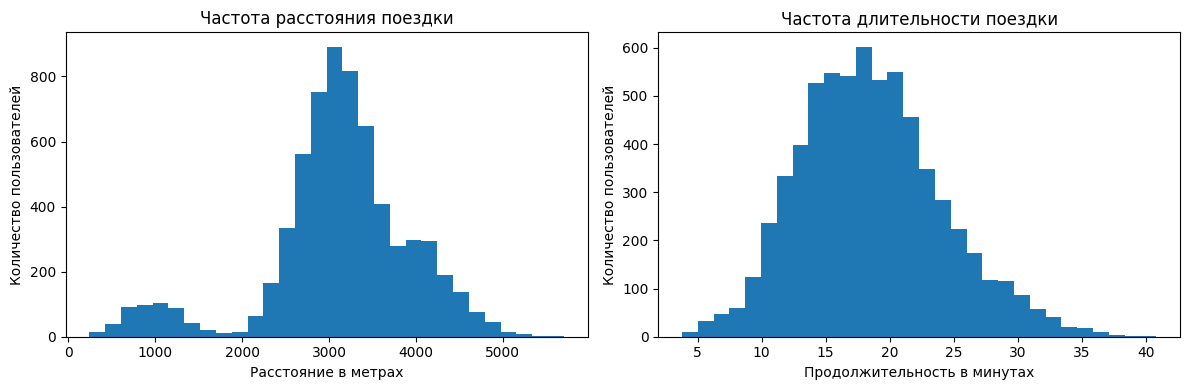

In [30]:
print("Пользователи с подпиской")
rides_frequencies(subscribed)

Пользователи без подписки


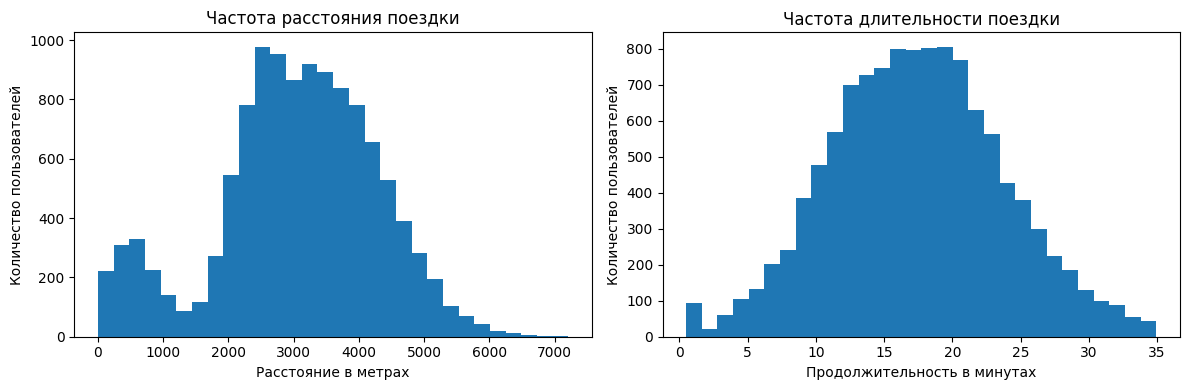

In [31]:
print("Пользователи без подписки")
rides_frequencies(unsubscribed)

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Следовало разместить графики на одной координатной сетке, так как проводится сравнительный анализ. Примерно вот так:</font>
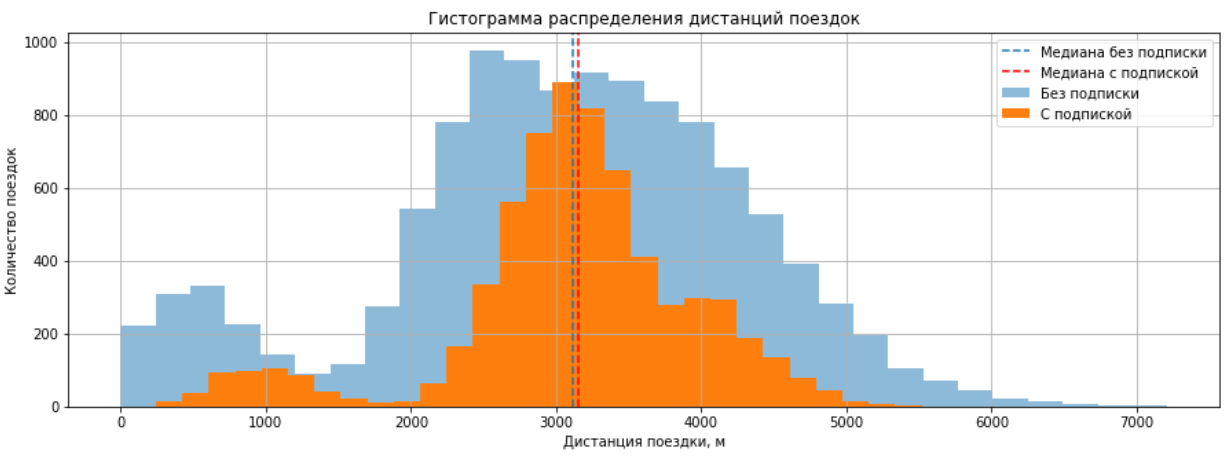

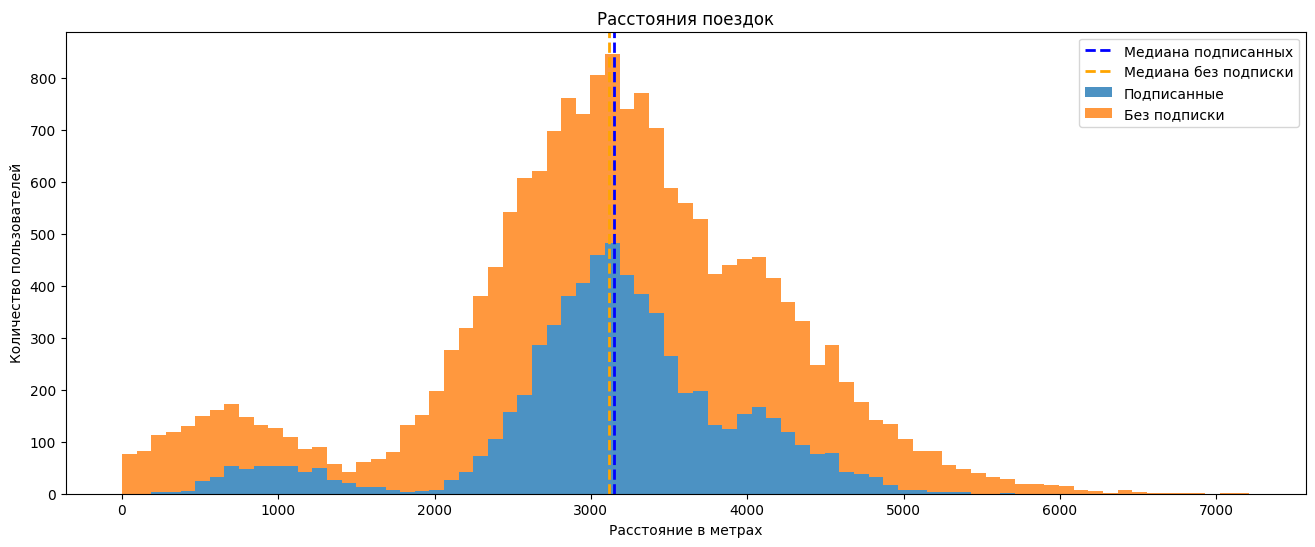

In [32]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))
ax1.hist([subscribed["distance"], unsubscribed["distance"]], bins = "auto", label=['Подписанные', 'Без подписки'], stacked = True, alpha = 0.8)
ax1.set_title('Расстояния поездок')
ax1.set_xlabel("Расстояние в метрах")
ax1.set_ylabel("Количество пользователей")
ax1.axvline(x=subscribed["distance"].median(), c="blue", label = "Медиана подписанных", ls = '--', lw = 2)
ax1.axvline(x=unsubscribed["distance"].median(), c="orange", label = "Медиана без подписки", ls = '--', lw = 2)
ax1.legend(loc='upper right')

plt.show()

Пользователи без подписки раньше заканчивают непродолжительные, менее 2 км, поездки. И чаще ездят на большие, более 5 км, расстояния.

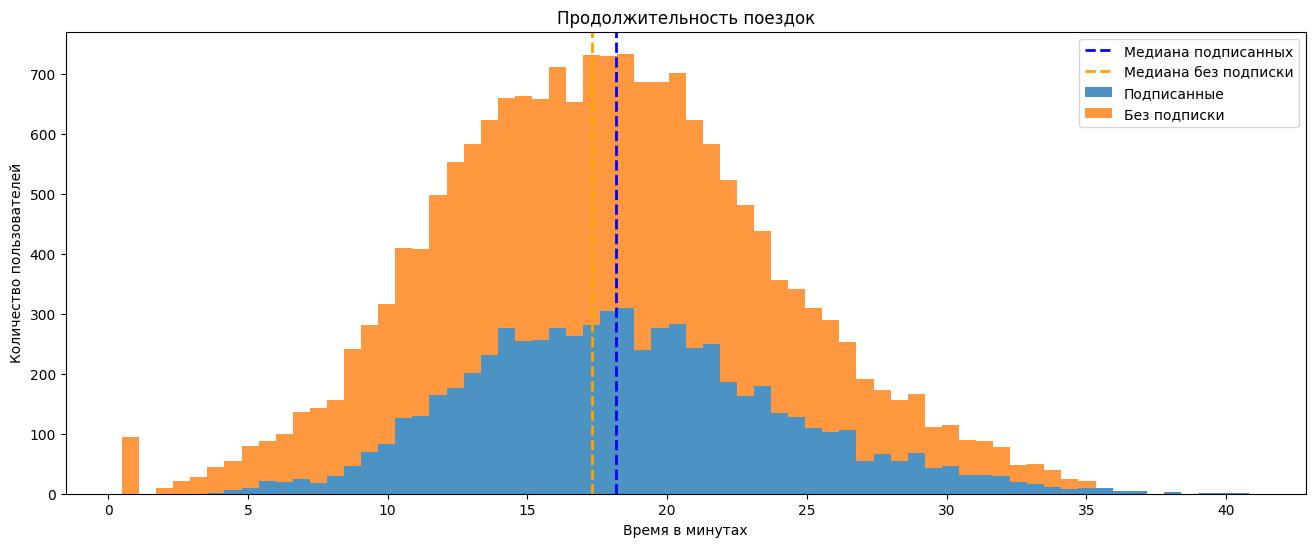

In [33]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))
ax1.hist([subscribed["duration"], unsubscribed["duration"]], bins = "auto", label=['Подписанные', 'Без подписки'], stacked = True, alpha = 0.8)
ax1.set_title('Продолжительность поездок')
ax1.set_xlabel("Время в минутах")
ax1.set_ylabel("Количество пользователей")
ax1.axvline(x=subscribed["duration"].median(), c="blue", label = "Медиана подписанных", ls = '--', lw = 2)
ax1.axvline(x=unsubscribed["duration"].median(), c="orange", label = "Медиана без подписки", ls = '--', lw = 2)
ax1.legend(loc='upper right')

plt.show()

Продолжительность поездок имеет аномалию для пользователей без подписки. Подписанные пользователи немного чаще едут дольше и при этом их продолжительность поездки имеет большую дисперсию. Так же пользователи без подписки крайне редкоездят более 36 минут за поездку, что нельзя сказать про пользователей с подпиской.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Каким образом "пользователи без подписки чаще заканчивают поездку на первой минуте"? Таках пользователей всего 95, а максимум находится в районе 19 минут.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
Изменил выводы выше.

## Подсчёт выручки

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Согласно заданию длительность каждой поездки должна быть округлена до целой минуты до суммирования за месяц.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
Изменил код.

In [34]:
df["duration"] = np.ceil(df["duration"])
user_stats = df.groupby(["user_id", "month_number"]).agg(
    total_distance = ("distance", "sum"),
    rides_count = ("distance", "count"),
    total_duration = ("duration", "sum")
).reset_index()
user_stats.head()

,user_id,month_number,total_distance,rides_count,total_duration
0,1,1,7027.511294,2,42.0
1,1,4,754.159807,1,7.0
2,1,8,6723.470560,2,46.0
3,1,10,5809.911100,2,32.0
4,1,11,7003.499363,3,56.0


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Не правильно создана таблица, агрегирование должно быть проведено по месяцам.</font>
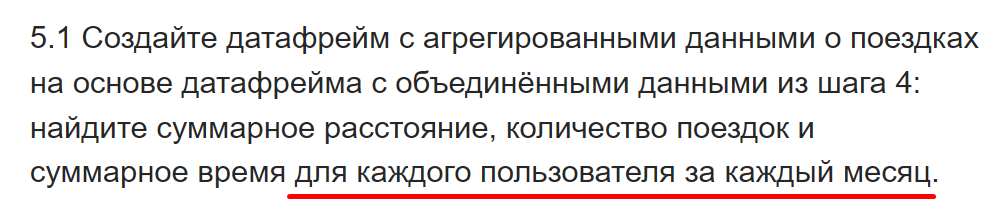

In [54]:
free = subscriptions[subscriptions["subscription_type"] == "free"].iloc[0]
sub = subscriptions[subscriptions["subscription_type"] == "ultra"].iloc[0]

def calculate_revenue(row):
    if users[users["user_id"] == row["user_id"]].iloc[0]["subscription_type"] == "free":
        return int(free["minute_price"] * math.ceil(row["total_duration"]) + free["start_ride_price"] * row["rides_count"] + free["subscription_fee"])
    else:
        return int(sub["minute_price"] * math.ceil(row["total_duration"]) + sub["start_ride_price"] * row["rides_count"] + sub["subscription_fee"])

user_stats["revenue"] = user_stats.apply(calculate_revenue, axis=1)
user_stats.head()

,user_id,month_number,total_distance,rides_count,total_duration,revenue
0,1,1,7027.511294,2,42.0,451
1,1,4,754.159807,1,7.0,241
2,1,8,6723.470560,2,46.0,475
3,1,10,5809.911100,2,32.0,391
4,1,11,7003.499363,3,56.0,535


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Неправильно сделан расчет выручки.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
Изменил код.

In [55]:
# Комментарий ревьюера
# Контроль суммы выручки
tmp, col_rev = user_stats.copy(), 'revenue'
print("Правильное значение суммы выручки 3878641, сумма выручки расчитанная в таблице:", tmp[col_rev].sum())

Правильное значение суммы выручки 3878641, сумма выручки расчитанная в таблице: 3878641


Создадим два датафрейма со статистикой по подписанными и не подписанным пользователям.

In [37]:
sub_user_stats = user_stats[user_stats["user_id"].isin(subscribed["user_id"])]
free_user_stats = user_stats.loc[user_stats.index.difference(sub_user_stats.index)]

print(f"Подписанных пользователей: {sub_user_stats['user_id'].count()}", f"Пользователей без подписки: {free_user_stats['user_id'].count()}", sep="\n")

Подписанных пользователей: 4533
Пользователей без подписки: 6798


### Гипотеза о длительности поездки

Т.к. пользователи с подпиской и без подписки не зависят друг от друга, проведём проверку гипотезы, что пользователи с подпиской и без неё тратят в среднем одинаковое время на поездки для них целиком. 

Нулевой гипотезой будем считать, что пользователи с подпиской и без неё тратят в среднем одинаковое количество времени на поездку.

Альтернативной гипотезой будем считать что пользователи с подпиской тратят на поездки больше времени. 

Установим уровень статистической значимости в 5%.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Необходимо отдельно формулировать нулевую гипотезу и отдельно альтернативную.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
Исправил текстовый блок.

In [56]:
alpha = .05

results = st.ttest_ind(subscribed["duration"], unsubscribed["duration"], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645613e-34
Отвергаем нулевую гипотезу


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Не правильно проводится тестирование, тестироваться должны выборки по времени каждой поездки пользователей, а не сумма за год. Почему не смущает результат теста равный 1?</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
Пересчитал гипотезу для плавильных срезов данных пользователей с учётом что каждая отдельная поездка это эксперимент. Значение равное единице не смутило из-за неопытности. Никогда раньше не проверел гипотезы. По сути значение 1 значит что статистика выборки, для которой рассматривается гипотеза, всегда принимает близкие к нулевой гипотезе значения, как я понимаю. Это значение имеет смысл в общем случае. Если бы у меня получилось значение больше 1 я бы точно смутился т.к. это невозможно. Но в данном случае я просто принял, что проверенная мной нулевая гипотеза не может быть отвержена.

In [39]:
# Комментарий ревьюера
sub_user_stats["total_duration"]

0       42.0
1        7.0
2       46.0
3       32.0
4       56.0
        ... 
4528    17.0
4529    45.0
4530    31.0
4531    16.0
4532    26.0
Name: total_duration, Length: 4533, dtype: float64

Делаем вывод, что пользователи с подпиской тратят больше времени на поездки, чем с подпиской.

### Гипотеза о расстоянии поездки

Чтобы проверить, какое расстояние в среднем проезжают пользователи с подпиской, будем считать что пользователь проезжает не больше 3130 метров за поездку нулевой гипотезой. Альтернативной гипотезой будем считать что пользователи проезжают в среднем более 3130 метров. Установим уровень статистической значимости в 5%.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Неправильно сформулированы нулевая и альтернативная гипотезы.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
Переписал формулировку.

In [60]:
alpha = .05
optimal_distance = 3130

results = st.ttest_1samp(subscribed["distance"], optimal_distance, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Не правильно проводится тестирование, тестироваться должна выборка по расстоянию каждой поездки пользователей.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
Исправил код проверки гипотезы.

Делаем вывод, что пользователи с подпиской проезжают в среднем не более 3130 метров.

### Гипотеза о выручке

Для начала подготовим два среза данных со средними значениями выручки по месяцам для двух групп пользователей.

Т.к. пользователи с подпиской не зависят от пользователей без подписки и наоборот, используем статистический тест для двух независимых выборок.

Сформулируем нулевую гипотезу как равенство месячных выручек для обеих групп пользователей.

Альтернативная гипотеза предполагает что выручка от пользоватей с подпиской выше, чем от пользователей без подписки. 

Предположем также что разброс выручки одинаков для обоих групп пользователей. Установим уровень статистической значимости в 5%.

In [63]:
alpha = .05

results = st.ttest_ind(sub_user_stats["revenue"], free_user_stats["revenue"], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Не правильно проводится тестирование, тестироваться должны выборки по месячной выручке каждого пользователя, а не суммарная выручка всех пользователей за месяц.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
Переписал формулировку. Исправил код тестирования гипотезы и вывод.

In [44]:
# Комментарий ревьюера
# sub_month_revenue

,ride_cost
month_number,
1,66697
2,54325
3,64003
4,63091
5,68839
6,64831
7,66055
8,62317
9,58891


Делаем вывод, что пользователи с подпиской приносят большую выручку компании.

### Гепотеза об обращениях в техподдержку

Т.к. выборки зависимы между собой (пользователи одни и те же), я бы выбрал проверку гепотезы о равенстве среднего значения генеральной совокупности до и после изменения и метод ttest_rel. Я бы выбрал в качестве альтернативной гипотезы то, что выборка обращений после изменений имеет меньшее среднее значение и проверял левостороннюю альтернативную гипотезу.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Это односторонняя или двусторонняя гипотеза?</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
Добавил предложение об альтернативной гипотезе и её направленности в ответ на вопрос.

## Распределения

### Промо акция

Т.к. у нас серия испытаний Бернулли, нужно брать биномиальное распределение для с.в. Подберём перебором такое количество экспериментов (выданных промокодов), при котором вероятность получить 100 подписчиков равна 5%.

In [45]:
subscription_prob = .1
plan_failure = .05
subscribers_count = 100

accuracy = math.inf
needed_promocodes_count = 0

for promocodes_count in range(100, 10000):
    difference = abs(plan_failure - st.binom.cdf(k = subscribers_count, n = promocodes_count, p = subscription_prob))
    if difference < accuracy:
        accuracy = difference
        needed_promocodes_count = promocodes_count

print(f"{needed_promocodes_count} промокодов нужно для выполнения плана.")



1172 промокодов нужно для выполнения плана.


### Уведомления

Проверим условия аппроксимации распределением Пуассона. Значение вероятности успеха нельзя считать малым т.к. оно 40%. Поэтому проверим условие применимости аппроксимации нормальным распределением.

In [46]:
notifications_count = 1_000_000
ctr = .4
engaged_users = 399_500

three_std = notifications_count * ctr - 3 * math.sqrt(notifications_count * ctr * (1 - ctr))

if three_std >= 0 and three_std <= notifications_count:
    print("Можно аппроксимировать нормальным распределением.")
else:
    print("Нельзя аппроксимировать нормальным распределением.")

Можно аппроксимировать нормальным распределением.


Построим график приближённого распределения.

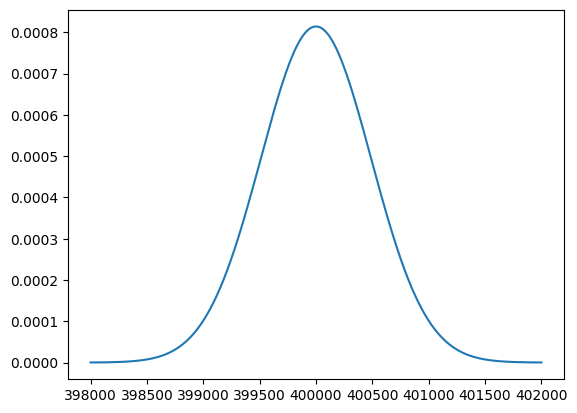

In [47]:
left = notifications_count * ctr - 2000
right = notifications_count * ctr + 2000

x = np.linspace(left, right, 1_000)

plt.plot(x, st.norm.pdf(x, notifications_count * ctr, math.sqrt(notifications_count * ctr * (1 - ctr))))

Посчитаем вероятность количества кликов меньшего чем 399_500.

In [48]:
prob = st.norm(notifications_count * ctr, math.sqrt(notifications_count * ctr * (1 - ctr))).cdf(engaged_users)

print(f"Вероятность что не более {engaged_users} пользователей откроют уведомление равна {prob * 100:.2f}%")

Вероятность что не более 399500 пользователей откроют уведомление равна 15.37%


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Молодец, справились с необязательным заданием.</font>

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Нет общего вывода исследования, он должен обобщать весь проект, включая анализ и предобработку данных, и кратко суммировать промежуточные выводы разделов всего исследования.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>
Добавил общий вывод исходя из целей исследования.

## Вывод работы

- Аналитикам стоит проверить аномалию для пользователей без подписки, которые за полминуты проезжают большие расстояния
- Т.к. в ходе проверок гипотез было выяснено, что пользователи с подпиской в среднем ездят дольше, проезжают при этом в среднем оптимальное с точки зрения обслуживания самокатов расстояние и в среднем приносят большую выручку, стоит заниматься маркетиногвыми активностями, которые повысят долю пользователей с подпиской.
- Для увеличения пользовательской базы подписчиков на 100 пользователей с вероятностью 95% можно раздавать по 1172 промокодов пользователям без подписки в месяц.

<font color='DarkBlue'><b>Заключительный комментарий ревьюера</b></font><br><br>
<font color='DarkGreen'>👌 Ярослав, проект очень хорошо и детально проработан. И дальше так держать!<br></font>
<font color='Red'>🛠 Что бы еще лучше сделать проект надо:</font><br>
<font color='Red'>🛠 Удалить дубликаты в датасетах. Сделать выводы по разделу предобработки данных. Графики и диаграммы необходимо оформить подписями осей и названием графика/диаграммы на русском языке. Написать выводы по разделу исследовательского анализа данных. Переделать промежуточные выводы по визуализации информации о времени поездок для пользователей обеих категорий. Сделать округление длительность каждой поездки до целой минуты перед суммированием длительности за месяц. Правильно создать датафрейм с агрегированными данными о поездках. Переделать расчет выручки. Переделать задание по тестированию гипотез по продолжительности поездок пользователям с подпиской. Переделать формулирование гипотез по среднему расстоянию проезжающему пользователями с подпиской. Переделать задание по тестированию гипотез по среднему расстоянию проезжающему пользователями с подпиской. Переделать задание по тестированию гипотез по выручке пользователей с подпиской. Сформулировать расширенный общий вывод проекта. <br></font>
<font color='DarkMagenta'>👉 При исправлении ошибок и недочетов приобретем дополнительный опыт и навыки!</font><br>
<font color='DarkGreen'>👌 Жду окончательный вариант! Удачи. </font>